### TASK:
Train and fine-tune a decision tree for the moons dataset by following these steps:
- a. Use make_moons(n_samples=10000, noise=0.4) to generate a moons
dataset.
- b. Use train_test_split() to split the dataset into a training set and a test set.
- c. Use grid search with cross-validation (with the help of the GridSearchCV
class) to find good hyperparameter values for a DecisionTreeClassifier.
Hint: try various values for max_leaf_nodes.
- d. Train it on the full training set using these hyperparameters, and measure
your model’s performance on the test set. You should get roughly 85% to
87% accuracy.


In [51]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=10000, noise=0.4, random_state=42)

In [52]:
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X_moons, y_moons, test_size=0.2, random_state=42)

In [76]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state=42, criterion="gini") #entropy

pg = {
    "max_leaf_nodes": [2, 3, 5, 7, 10, 25, 50, 100],
}

GridSrch = GridSearchCV(dtc, param_grid=pg, cv=5)

In [77]:
GridSrch.fit(X_train, y_train)
print(GridSrch.best_estimator_)
print(f'Train score: {GridSrch.best_score_}')
y_pred = GridSrch.best_estimator_.predict(X_test)

from sklearn.metrics import accuracy_score

print(f'Test score: {accuracy_score(y_test, y_pred)}')

DecisionTreeClassifier(max_leaf_nodes=25, random_state=42)
Train score: 0.859
Test score: 0.872


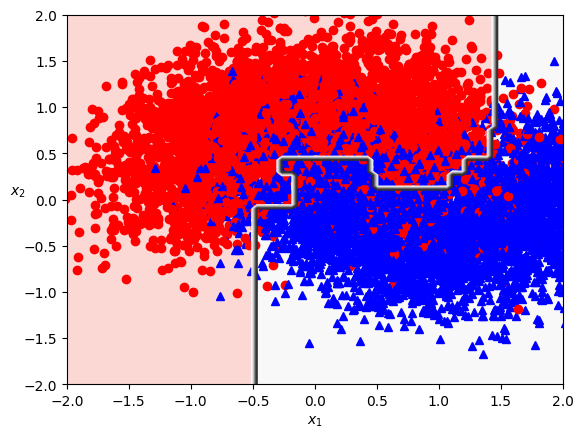

In [78]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

def plot_decision_boundary(clf, X, y, axes, cmap):
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    colors = {"Wistia": ["#78785c", "#c47b27"], "Pastel1": ["red", "blue"]}
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[cmap][idx], marker=markers[idx], linestyle="none")
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)
    
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

plot_decision_boundary(GridSrch.best_estimator_, X_train, y_train,
                       axes=[-2, 2, -2, 2], cmap="Pastel1")
plot_decision_boundary(GridSrch.best_estimator_, X_test, y_test,
                       axes=[-2, 2, -2, 2], cmap="Pastel1")

## TASK:
Grow a forest by following these steps:
- a. Continuing the previous exercise, generate 1,000 subsets of the training set,
each containing 100 instances selected randomly. Hint: you can use ScikitLearn’s ShuffleSplit class for this.
- b. Train one decision tree on each subset, using the best hyperparameter values
found in the previous exercise. Evaluate these 1,000 decision trees on the test
set. Since they were trained on smaller sets, these decision trees will likely
perform worse than the first decision tree, achieving only about 80%
accuracy.
- c. Now comes the magic. For each test set instance, generate the predictions of
the 1,000 decision trees, and keep only the most frequent prediction (you can
use SciPy’s mode() function for this). This approach gives you majority-vote
predictions over the test set.
- d. Evaluate these predictions on the test set: you should obtain a slightly higher
accuracy than your first model (about 0.5 to 1.5% higher). Congratulations,
you have trained a random forest classifier!


In [91]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances,
                  random_state=42)

for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

In [95]:
from sklearn.base import clone

forest = [clone(GridSrch.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    accuracy_scores.append(accuracy_score(y_test, 
                                          tree.predict(X_test)))


In [101]:
np.mean(accuracy_scores)

np.float64(0.798354)

In [102]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [103]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

In [104]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.8735